In [33]:
!pip install geopy

In [128]:
import os

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링
path = "Jupyter Temp/프로젝트/"
pd.set_option("display.max_rows",None)

In [35]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

# 1. date 변수 변환


In [36]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
train["date"] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday

In [38]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


In [39]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday

In [40]:
train.groupby(by="weekday")["18~20_ride"].sum()

weekday
0    104073.0
1     87220.0
2     88404.0
3     74122.0
4     59451.0
5     48419.0
6     54306.0
Name: 18~20_ride, dtype: float64

# 2. in_out 변수 변환


In [41]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [42]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

# 3. 변수간 상관관계 확인

In [43]:
cor=train.corr()

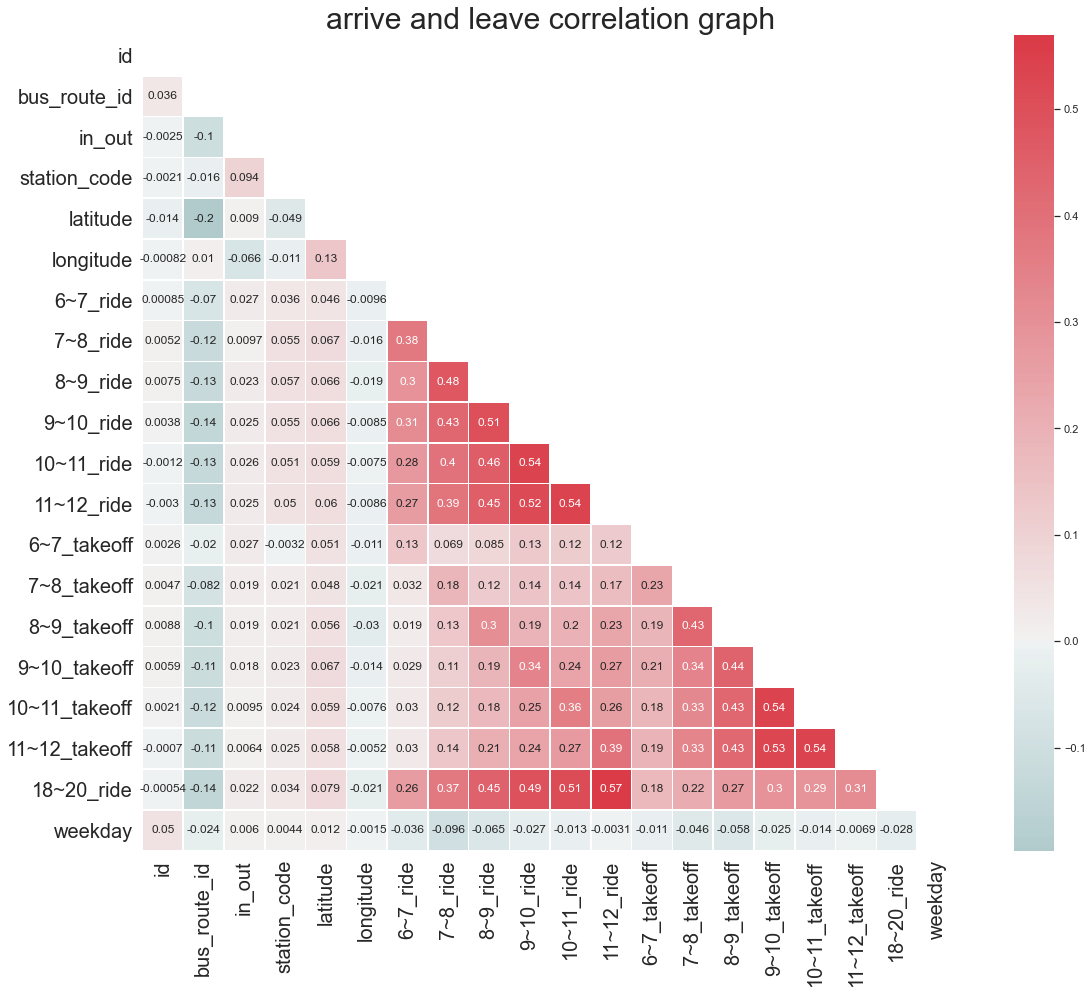

In [44]:
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [45]:
del train['station_name']
del test['station_name']

# 4. 좌표 데이터를 이용한 Feature Engineering
## 4-1. 측정소 위치 및 정류장 위치 확인

In [46]:
area = pd.read_excel("Jupyter Temp/프로젝트/행정_법정동 중심좌표.xlsx")

In [47]:
area.head()

,코드,시도,시군구,읍면동,하위,위도,경도,코드종류
0,1111051500,서울특별시,종로구,청운효자동,NaN,37.584009,126.970626,H
1,1111053000,서울특별시,종로구,사직동,NaN,37.575408,126.965944,H
2,1111054000,서울특별시,종로구,삼청동,NaN,37.590758,126.980996,H
3,1111055000,서울특별시,종로구,부암동,NaN,37.594768,126.965574,H
4,1111056000,서울특별시,종로구,평창동,NaN,37.613029,126.974485,H


In [48]:
area = area.drop(["코드","하위","코드종류"],axis=1)
area = area[area["시도"]=="제주특별자치도"]
area = area.groupby(by = ["시군구","읍면동"]).median().reset_index()
area["lat_lon"] = list(zip( area['위도'],area['경도'] ))
area

,시군구,읍면동,위도,경도,lat_lon
0,서귀포시,강정동,33.248323,126.491240,"(33.248323, 126.49124)"
1,서귀포시,남원읍,33.298845,126.700156,"(33.2988445, 126.70015649999999)"
2,서귀포시,대륜동,33.248173,126.511445,"(33.248173, 126.511445)"
3,서귀포시,대정읍,33.256852,126.255028,"(33.2568515, 126.255028)"
4,서귀포시,대천동,33.250783,126.477610,"(33.250783, 126.47761000000001)"
...,...,...,...,...,...
93,제주시,해안동,33.453268,126.462749,"(33.453268, 126.462749)"
94,제주시,화북동,33.520222,126.565474,"(33.520222, 126.565474)"
95,제주시,화북이동,33.505534,126.562373,"(33.505534, 126.562373)"
96,제주시,화북일동,33.520301,126.565986,"(33.520301, 126.565986)"


## 4-2. 측정소와 정류장 사이 거리 계산 적용


In [49]:
def nearest(lat,lon):
  near = ["시군구","읍면동",100000000000]
  for i in range(len(area)):
    areaCenter = area["lat_lon"][i]
    distance = np.sqrt((lat-areaCenter[0])**2 + (lon-areaCenter[1])**2)
    if distance < near[2]:
      near = [area["시군구"][i], area["읍면동"][i],distance]
  return near[:2]

In [64]:
station_ll = train.groupby(by="station_code")[["latitude","longitude"]].mean().reset_index() 
display(station_ll)

,station_code,latitude,longitude
0,1,33.52438,126.54433
1,2,33.49527,126.45618
2,3,33.49546,126.45623
3,4,33.49488,126.46137
4,5,33.49508,126.46122
...,...,...,...
3558,6115048,33.49558,126.95411
3559,6115052,33.51123,126.96567
3560,6115059,33.50731,126.95093
3561,6115100,33.24873,126.50799


In [70]:
station_ll = station_ll.merge(test.groupby(by="station_code")[["latitude","longitude"]].mean().reset_index(),
                              how="outer")
station_ll = station_ll.groupby("station_code").mean().reset_index()
station_ll

,station_code,latitude,longitude
0,0,33.486549,126.499152
1,1,33.524380,126.544330
2,2,33.495270,126.456180
3,3,33.495460,126.456230
4,4,33.494880,126.461370
...,...,...,...
3596,6115055,33.518020,126.953160
3597,6115059,33.507310,126.950930
3598,6115061,33.509180,126.948090
3599,6115100,33.248730,126.507990


In [71]:
station_ll["lat_lon"] = list(zip(station_ll["latitude"],station_ll["longitude"]))
station_ll["시군구"] = station_ll["lat_lon"].apply(lambda x : nearest(x[0],x[1])[0] )
station_ll["읍면동"] = station_ll["lat_lon"].apply(lambda x : nearest(x[0],x[1])[1] )

In [72]:
sgg_dict = dict(zip(station_ll["station_code"],station_ll["시군구"]))
ymd_dict = dict(zip(station_ll["station_code"],station_ll["읍면동"]))

In [73]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [74]:
train["시군구"] = train["station_code"].apply(lambda x: sgg_dict[x])
train["읍면동"] = train["station_code"].apply(lambda x: ymd_dict[x])

test["시군구"] = test["station_code"].apply(lambda x: sgg_dict[x])
test["읍면동"] = test["station_code"].apply(lambda x: ymd_dict[x])

In [75]:
train.head()

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,시군구,읍면동
0,0,2019-09-01,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,제주시,도두이동
1,1,2019-09-01,4270000,1,357,33.48944,126.48508,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,제주시,도두이동
2,2,2019-09-01,4270000,1,432,33.48181,126.47352,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,제주시,이호이동
3,3,2019-09-01,4270000,0,1579,33.50577,126.49252,0.0,17.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,제주시,용담2동
4,4,2019-09-01,4270000,0,1646,33.25579,126.41260,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,서귀포시,색달동


In [76]:
train["읍면동"].unique()

array(['도두이동', '이호이동', '용담2동', '색달동', '예래동', '대포동', '상예동', '대천동', '송산동',
       '천지동', '안덕면', '월평동', '대륜동', '강정동', '법환동', '연동', '오라삼동', '오라일동',
       '서호동', '하원동', '추자면', '우도면', '조천읍', '삼양동', '삼양일동', '이도1동', '일도2동',
       '화북동', '구좌읍', '표선면', '성산읍', '중앙동', '남원읍', '외도동', '외도일동', '한림읍',
       '애월읍', '대정읍', '한경면', '회수동', '오라동', '아라일동', '이도이동', '이도2동', '아라이동',
       '도련일동', '해안동', '봉개동', '상효동', '호근동', '영천동', '도남동', '삼도1동', '일도일동',
       '용담1동', '건입동', '오라이동', '노형동', '오등동', '아라동', '도평동', '신효동', '서귀동',
       '효돈동', '하효동', '회천동', '일도이동', '용강동', '화북이동', '중문동', '영남동', '토평동',
       '도순동', '용담이동', '삼도2동', '삼도이동', '삼도일동', '이호일동', '내도동', '삼양이동',
       '삼양삼동', '화북일동', '일도1동', '이도일동', '도련이동', '외도이동', '도두일동', '영평동',
       '용담일동', '용담삼동', '이호동', '도두동', '보목동', '정방동', '동홍동', '하예동', '서홍동'],
      dtype=object)

# 5. 외부 실제 측정 데이터 활용


In [77]:
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653)

In [78]:
wth_statioin = pd.DataFrame({"지역":["제주","고산","성산","서귀포"],"위도" : [33.51411,33.29382,33.38677,33.24616],"경도":[126.52969,126.16283,126.8802,126.5653]})

In [79]:
wth_statioin

,지역,위도,경도
0,제주,33.51411,126.52969
1,고산,33.29382,126.16283
2,성산,33.38677,126.88020
3,서귀포,33.24616,126.56530


In [80]:
def rain_nearest(lat,lon):
  near = ["지역",100000000000]
  for i in range(len(wth_statioin)):
    areaCenter = [wth_statioin.iloc[i,1],wth_statioin.iloc[i,2]]
    distance = np.sqrt((lat-areaCenter[0])**2 + (lon-areaCenter[1])**2)
    if distance < near[1]:
      near = [wth_statioin.iloc[i,0],distance]
  return near[0]

In [87]:
station_ll["weather_area"] = station_ll["lat_lon"].apply(lambda x : rain_nearest(x[0],x[1]))

In [88]:
station_ll

,station_code,latitude,longitude,lat_lon,시군구,읍면동,weather_area
0,0,33.486549,126.499152,"(33.486549, 126.499152)",제주시,오라삼동,제주
1,1,33.524380,126.544330,"(33.524379999999965, 126.54433000000012)",제주시,건입동,제주
2,2,33.495270,126.456180,"(33.49526999999999, 126.4561800000003)",제주시,이호일동,제주
3,3,33.495460,126.456230,"(33.49546000000006, 126.4562299999998)",제주시,이호일동,제주
4,4,33.494880,126.461370,"(33.494880000000144, 126.46137000000007)",제주시,이호이동,제주
...,...,...,...,...,...,...,...
3596,6115055,33.518020,126.953160,"(33.51802, 126.95316)",제주시,우도면,성산
3597,6115059,33.507310,126.950930,"(33.507310000000004, 126.95093)",제주시,우도면,성산
3598,6115061,33.509180,126.948090,"(33.50918, 126.94809)",제주시,우도면,성산
3599,6115100,33.248730,126.507990,"(33.248729999999895, 126.50798999999895)",서귀포시,대륜동,서귀포


In [89]:
wth_dict = dict(zip(station_ll["station_code"],station_ll["weather_area"]))

In [90]:
train["weather_area"] = train["station_code"].apply(lambda x: wth_dict[x])
test["weather_area"] = test["station_code"].apply(lambda x: wth_dict[x])

In [91]:
train.head()

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,시군구,읍면동,weather_area
0,0,2019-09-01,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,제주시,도두이동,제주
1,1,2019-09-01,4270000,1,357,33.48944,126.48508,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6,제주시,도두이동,제주
2,2,2019-09-01,4270000,1,432,33.48181,126.47352,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,6,제주시,이호이동,제주
3,3,2019-09-01,4270000,0,1579,33.50577,126.49252,0.0,17.0,6.0,...,0.0,0.0,0.0,0.0,0.0,53.0,6,제주시,용담2동,제주
4,4,2019-09-01,4270000,0,1646,33.25579,126.41260,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,6,서귀포시,색달동,서귀포


In [95]:
# https://data.kma.go.kr/cmmn/main.do
#데이터 불러오기
raining=pd.read_csv("Jupyter Temp/프로젝트/OBS_ASOS_TIM_20210114113345.csv",engine='python',encoding="cp949")

In [96]:
raining.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,184,제주,2019-09-01 01:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
1,184,제주,2019-09-01 02:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
2,184,제주,2019-09-01 03:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
3,184,제주,2019-09-01 04:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN
4,184,제주,2019-09-01 05:00,23.3,NaN,1.2,180.0,71,1013.6,1016.0,NaN,NaN


In [97]:
raining["지점명"].unique()

array(['제주', '고산', '성산', '서귀포'], dtype=object)

In [98]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 
raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

In [99]:
# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
raining = raining[ (raining['time']>12) ]

In [100]:
raining = raining.groupby(['지점명','일시'])[['기온(°C)','강수량(mm)',"습도(%)","풍속(m/s)"]].mean().reset_index()

In [101]:
raining.head()

,지점명,일시,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,고산,2019-09-01,22.018182,0.800000,90.727273,2.972727
1,고산,2019-09-02,26.145455,0.700000,95.545455,3.745455
2,고산,2019-09-03,25.254545,3.866667,98.272727,2.736364
3,고산,2019-09-04,24.463636,0.266667,91.636364,4.936364
4,고산,2019-09-05,27.136364,NaN,91.909091,4.690909


In [102]:
raining.rename(columns={"일시":"date","지점명":"weather_area"},inplace=True)
raining.fillna(method="bfill",inplace=True)

In [103]:
raining.head()

,weather_area,date,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,고산,2019-09-01,22.018182,0.800000,90.727273,2.972727
1,고산,2019-09-02,26.145455,0.700000,95.545455,3.745455
2,고산,2019-09-03,25.254545,3.866667,98.272727,2.736364
3,고산,2019-09-04,24.463636,0.266667,91.636364,4.936364
4,고산,2019-09-05,27.136364,2.609091,91.909091,4.690909


In [104]:
raining["date"] = pd.to_datetime(raining["date"])

In [106]:
train=pd.merge(train,raining,how='left',on=['weather_area','date'])
test=pd.merge(test,raining,how='left',on=['weather_area','date'])

In [107]:
train.head()

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,11~12_takeoff,18~20_ride,weekday,시군구,읍면동,weather_area,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,0,2019-09-01,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,6,제주시,도두이동,제주,22.727273,2.272727,89.363636,2.318182
1,1,2019-09-01,4270000,1,357,33.48944,126.48508,1.0,4.0,4.0,...,0.0,5.0,6,제주시,도두이동,제주,22.727273,2.272727,89.363636,2.318182
2,2,2019-09-01,4270000,1,432,33.48181,126.47352,1.0,1.0,0.0,...,0.0,2.0,6,제주시,이호이동,제주,22.727273,2.272727,89.363636,2.318182
3,3,2019-09-01,4270000,0,1579,33.50577,126.49252,0.0,17.0,6.0,...,0.0,53.0,6,제주시,용담2동,제주,22.727273,2.272727,89.363636,2.318182
4,4,2019-09-01,4270000,0,1646,33.25579,126.41260,0.0,0.0,0.0,...,0.0,0.0,6,서귀포시,색달동,서귀포,22.127273,1.627273,98.454545,2.109091


In [109]:
train = pd.get_dummies(train,columns=['시군구'])
train = pd.get_dummies(train,columns=['읍면동'])
train = pd.get_dummies(train,columns=['weather_area'])

test = pd.get_dummies(test,columns=['시군구'])
test = pd.get_dummies(test,columns=['읍면동'])
test = pd.get_dummies(test,columns=['weather_area'])

In [110]:
train.shape, test.shape

((415423, 128), (228170, 127))

# 6. randomforest을 활용한 모델링
## 6-1. 변수 선택 및 train data sampling


In [111]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'latitude',
       'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       ...
       '읍면동_화북동', '읍면동_화북이동', '읍면동_화북일동', '읍면동_회수동', '읍면동_회천동', '읍면동_효돈동',
       'weather_area_고산', 'weather_area_서귀포', 'weather_area_성산',
       'weather_area_제주'],
      dtype='object', length=128)

In [113]:
X_train=train.drop(columns=["id","date","18~20_ride","station_code"])
y_train = train["18~20_ride"]

In [116]:
X_test=test.drop(columns=["id","date","station_code"])

In [117]:
X_train.shape, y_train.shape

((415423, 124), (415423,))

In [118]:
X_test.shape

(228170, 124)

## 6-2. Neural Networks

In [119]:
X_train.head()

,bus_route_id,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,...,읍면동_화북동,읍면동_화북이동,읍면동_화북일동,읍면동_회수동,읍면동_회천동,읍면동_효돈동,weather_area_고산,weather_area_서귀포,weather_area_성산,weather_area_제주
0,4270000,1,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,1
1,4270000,1,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,...,0,0,0,0,0,0,0,0,0,1
2,4270000,1,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,4270000,0,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,...,0,0,0,0,0,0,0,0,0,1
4,4270000,0,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [120]:
y_train.head()

0     0.0
1     5.0
2     2.0
3    53.0
4     0.0
Name: 18~20_ride, dtype: float64

In [147]:
X_train.shape

(415423, 124)

In [156]:
model = Sequential()


model.add(Dense(32,input_dim = 124))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1))

In [157]:
model.compile(loss="mse",optimizer='adamax',metrics="acc")

In [ ]:
hist = model.fit(X_train, y_train, epochs=200,batch_size=256)

Epoch 1/200
1623/1623 [==============================] - 9s 4ms/step - loss: 21.4702 - acc: 0.2726
Epoch 2/200
1623/1623 [==============================] - 7s 5ms/step - loss: 22.9641 - acc: 0.2938
Epoch 3/200
1623/1623 [==============================] - 8s 5ms/step - loss: 20.6991 - acc: 0.2873
Epoch 4/200
1623/1623 [==============================] - 7s 5ms/step - loss: 20.3450 - acc: 0.2805
Epoch 5/200
1623/1623 [==============================] - 9s 6ms/step - loss: 20.2868 - acc: 0.2777
Epoch 6/200
1623/1623 [==============================] - 8s 5ms/step - loss: 23.2721 - acc: 0.2806
Epoch 7/200
1623/1623 [==============================] - 9s 5ms/step - loss: 22.2029 - acc: 0.2898
Epoch 8/200
1623/1623 [==============================] - 8s 5ms/step - loss: 22.1067 - acc: 0.2767
Epoch 9/200
1623/1623 [==============================] - 9s 5ms/step - loss: 21.2867 - acc: 0.2829
Epoch 10/200
1623/1623 [==============================] - 8s 5ms/step - loss: 22.2780 - acc: 0.2890
Epoch 11/

In [ ]:
test['18~20_ride'] = model.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

In [ ]:
test[['id','18~20_ride']].to_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/1. 버스 승차량 예측 프로젝트/DL/submission/submission_0115(2).csv",index=False)